# Tools

NuclearTools has pint unit integration so values input with units will output results with like units.

To begin, simply input the module as seen below and pint can be input seperately to help keeps units consistent through analysis.

In [1]:
import NuclearTools.Tools as nt
import pint
import numpy as np
U = pint.UnitRegistry()

# Binding Energy

In [2]:
print(nt.BE_per_nucleon('U-235'))

7.390909556951814 megaelectron_volt


# Mass and Number Density

In [3]:
print('Atomic mass is    ', nt.atomic_mass("U-235"))

print('Standard_mass is  ', nt.standard_mass('U'))

print('Atomic number is  ', nt.atomic_number('U'))

print('Molecular mass is ', nt.molec_mass('UO2'))

print('Molecular mass is ', nt.molec_mass('Y3Al6BO3Si6O18OH4'))

print('Number density is ', nt.num_density('U-235', density=10.1))

Atomic mass is     235.0439299
Standard_mass is   238.02891
Atomic number is   92
Molecular mass is  270.02771
Molecular mass is  963.9493416
Number density is  2.5882392804255316e+22 / centimeter ** 3


# Q-Value

When finding the Q-value, reactants are input first in a list, followed by the list of products.  Neutrons are indicated by 'n', and protons are indicated by 'p'.

In [4]:
print(nt.Q_value(['n', 'U-235'], ['Kr-92', 'Ba-141', '3n']))

173.2898030655273 megaelectron_volt


# Elastic or Coherent Scattering Energy After Collision

First give the atom that is collided with, then the angle in degrees of rebound, and finally the initial energy where we can make use of pint to keep track of units.

In [5]:
print(nt.coh_scatter_energy('Cs-137', 25, 5 * U.MeV))

4.993165810676886 megaelectron_volt


# Cross Section Data and Plotting

This module can also pull in cross section data from https://www-nds.iaea.org/public/download-endf/.

The VIII version of ENDF (most current) is the one of choice in this package.  Each time a request is sent for a specific set of cross sections, they are pulled from this online repo and a temporary file is created with the data to ease the memory usage of a program. 

To pull in cross section data, first create an object around the reaction of interest, for example the (n,p) reaction of Fe-54.

The MF and MT parameters define what the cross section is versus and the type of reaction.  For example, MF=3 indicates cross section data versus energy and MT=103 indicates the (n,p) reaction.  For MT, input can be either a number or the reaction relating to that number such as '(n,p)' and for common reactions such as fission you can simply type MT = 'fission' or MT='(n,fission)'. 

In [6]:
iron_object = nt.cross_section('Fe-54', MF=3, MT='(n,p)')

cross_sections = iron_object.cross_sections

energies = iron_object.indep_var

Here we have created an iron object and no extra functions must be called to directly access the cross sections and the independent variables associated with each value.  Above is how the cross sections are accessed and how the independent variables are accessed as well, which is energy in our case since MF=3. 

We can also make a csv with two columns listing the independent variable data followed by the cross sections in the second column.  This file is saved to the current working directory. 

Another benefit is the ability to create a singular average by first defining an averaging function and then calling the single_average function.  Both of these abilities can be seen below.

In [7]:
iron_object.make_csv(filename="cross_data")

def averaging_function(energy):
    return .454*np.exp(-energy/.965)*np.sinh(np.sqrt(2.29*energy))

print(iron_object.single_average(func=averaging_function, func_units='MeV'))

0.08157602172188134


Lastly plotting is done by simply calling the plot function with no arguments.

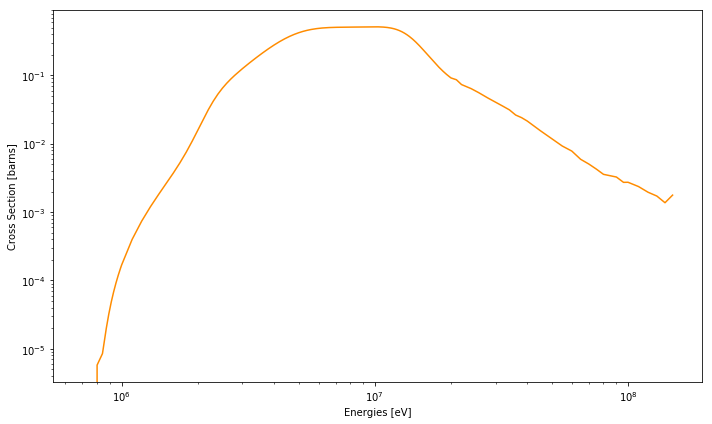

In [8]:
iron_object.plot()

# Disclaimer

For those unfamiliar with pint, the python units package, to obtain only the numerical value from any ouput simply add .magnitude to the end of any pint object.  For example ...

In [9]:
x = 5 * U.m
print(x)

print(x.magnitude)

print(x.units)

5 meter
5
meter


# ThermalHydraulics

In [10]:
import NuclearTools.ThermalHydraulics as th

In [11]:
obj = th.reactor_temperatures(
        power=3411*U.MW,
        height=144*U.inch,
        pitch=0.496*U.inch,
        T_inf=(560+458.67)*U.degR,
        PF_power=2.5,
        PF_axial=1.5,
        D_clad=0.374*U.inch,
        c_thick=0.0225*U.inch,
        k_c=9.6*U.Btu/(U.hour*U.feet*U.rankine),
        n_rods=50952,
        h_g=1000*U.Btu/(U.hour*U.feet**2*U.rankine),
        pressure=2250*U.psi,
        mass_flux=2.62*10**6*U.lb/(U.hour*U.feet**2),
        percent=0.975,
        cp=1.38*U.Btu/(U.lb*U.degR),
        U=U,
        T_sat=(652.74+460)*U.degR)

In [12]:
print('Coolant: ', obj.T_coolant(72*U.inch, obj.q_dprime_avg))

print('Clad :', obj.T_clad(72*U.inch, obj.q_dprime_avg))

print(obj.T_fuel(72*U.inch, obj.q_dprime_avg))

print(obj.max_T_clad(obj.q_dprime_avg))

print(obj.max_PF_boiling(obj.q_dprime_max))

Coolant:  1050.1999605634942 degR
Clad : 1081.2653424012985 degR
2675.1283991185696 degR
1094.4679716312362 degR
1.8615933508945115


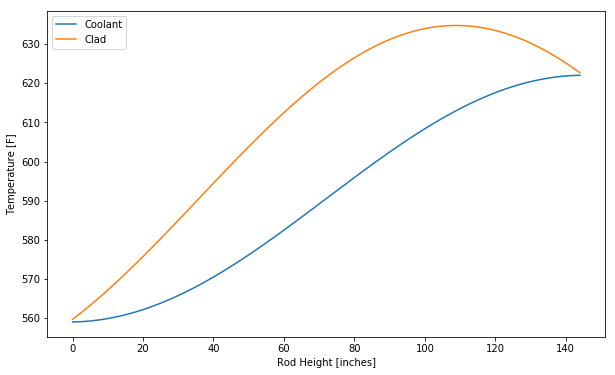

In [13]:
obj.plot(obj.q_dprime_avg, coolant=True, clad=True, units=U.degF)

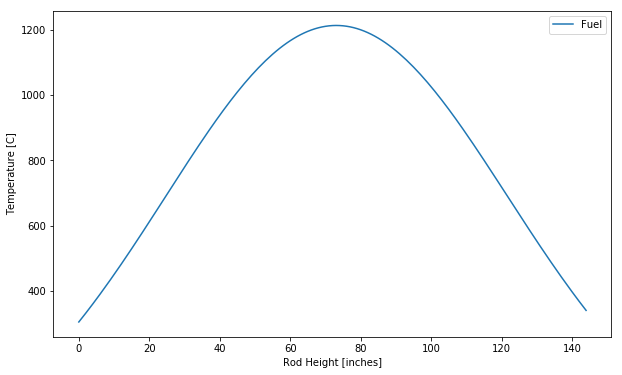

In [14]:
obj.plot(obj.q_dprime_avg, fuel=True, units=U.degC)